In [1]:
import numpy as np
import xarray as xr
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

/home/philippotn/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [32]:
#simu = 'AMOPL'
simu = 'DMOPL'
# simu = 'A0W0V'
# simu = 'ATRI2'
# simu = 'ACON2'
# simu = 'AMO20'
# simu = 'CTRI2'
# simu = 'CFLAT'
# simu = 'CMO10'

orog=True

# userPath = '/cnrm/tropics/user/philippotn'
userPath = '/home/philippotn'
    
if userPath == '/home/philippotn':
    #dataPath = userPath+'/Documents/SIMU_LES/'
    dataPath = userPath+'/Documents/NO_SAVE/'
    objectsPath = userPath+'/Documents/objects/LES_'+simu+'/1M_thermals/'
else:
    dataPath = userPath+'/LES_'+simu+'/NO_SAVE/'
    objectsPath = userPath+'/LES_'+simu+'/characs_objects/1M_thermals/'

if simu == 'AMOPL':
    seg = 'M200m'# ; lFiles = [dataPath + 'AMOPL.1.200m1.OUT.{:03d}.nc'.format(i) for i in range(1,241,1)] + [dataPath + 'AMOPL.1.200m2.OUT.{:03d}.nc'.format(i) for i in range(1,722,1)]
    lFiles = [dataPath + 'AMOPL.1.200m1.OUT.{:03d}.nc'.format(i) for i in [60,120,180,240]]+[dataPath + 'AMOPL.1.200m2.OUT.{:03d}.nc'.format(i) for i in [60,120,180,240,300,360,420,480,540,600,660,720]]
elif simu== 'A0W0V':
    seg = 'S200m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(1,962,1)]
elif simu== 'ATRI2':
    seg = 'S200m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(1,962,60)]
elif simu== 'ACON2':
    seg = 'S200m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(1,962,1)]
elif simu== 'AMO20':
    seg = 'M200m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in [1,61,121,181,241,301,361,421,481,541,601,661,699]]#range(1,961,1)]
elif simu== 'CTRI2':
    seg = 'M100m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(1,872,1)]
elif simu== 'CFLAT':
    seg = 'S100m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(1,872,1)]
elif simu== 'CMO10':
    seg = 'M100m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(2,3,1)]

elif simu in ['DFLAT','DF500','DTRI2','DMO10','DMOPL']:
    seg = 'M100m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:04d}.nc'.format(i) for i in range(6,109,6)]
    
f0 = xr.open_dataset(lFiles[0],engine='h5netcdf')

nx1 = 1 ; nx2 = len(f0.ni)-1
ny1 = 1 ; ny2 = len(f0.nj)-1
nz1 = 1 ; nz2 = len(f0.level)-1

x = np.array(f0.ni)[nx1:nx2]
y = np.array(f0.nj)[ny1:ny2]
z = np.array(f0.level)[nz1:nz2]
z_ = np.array(f0.level_w)[nz1:nz2]
dz = z_[1:]-z_[:-1]
dz = np.append(dz,dz[-1])

dx = x[1]-x[0]
nt,nz,ny,nx = len(lFiles),len(z),len(y),len(x)

if orog:
    ZS = xr.open_dataset(dataPath+simu+'_init_'+seg+'_pgd.nc')['ZS'][ny1:ny2,nx1:nx2].data
    ZSmean = np.mean(ZS)
    MO = ZS>ZSmean # Mountain region (upper one)
    PL = np.logical_not(MO) # Plain region (lower one)
else:
    ZS = np.zeros((ny,nx))
    
nt = len(lFiles)

def printProgressBar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 50, fill = '█', printEnd = "\r"):
    ratio = str(iteration)+' / '+str(total)
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {ratio} {suffix}', end = printEnd)
    if iteration == total: # Print New Line on Complete
        print()

In [30]:
list_objects=[]
list_area=[]
list_charac=[]
list_pos=[]
lFiles = [objectsPath+'objects_charac_area_pos.{:03d}.npz'.format(i) for i in range(1,1+nt)]
print("Chargement des données de charactérisation d'objets :")
for it,file in enumerate(lFiles):
    cap = np.load(file)
    list_objects.append(cap['objects'])
    list_area.append(cap['area'])
    list_pos.append(cap['pos'])
    list_charac.append(cap['charac'])
    printProgressBar(it+1,nt)

Chargement des données de charactérisation d'objets :
 |██████████████████████████████████████████████████| 18 / 18 


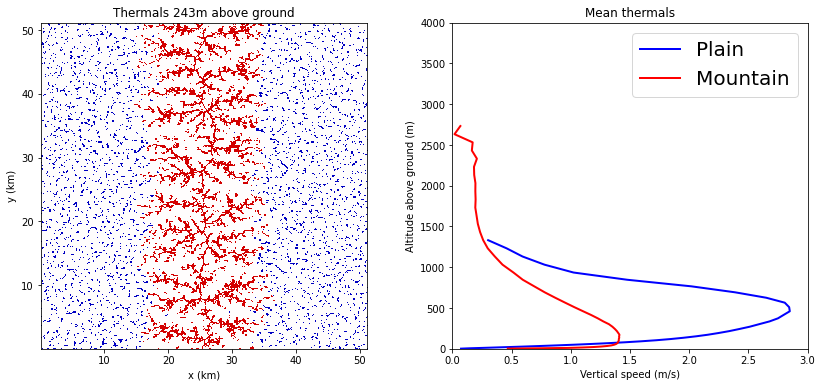

In [52]:
it = 5
iz=20
fig,ax = plt.subplots(ncols=2,figsize=(14,6))

#PL = list_charac[it][:,0,5,0] > 98500
#MO = list_charac[it][:,0,5,0] < 98500
PL = list_charac[it][:,0,5,2] > 90000
MO = list_charac[it][:,0,5,2] < 90000
MO[0] = False


objects_MO = np.arange(0,len(list_charac[it]))[MO]
map_objects_MO = - np.array(list_objects[it][iz,:,:] >0 , dtype=np.float32)
for j in range(ny):
    for i in range(nx):
        if list_objects[it][iz,j,i] in objects_MO:
            map_objects_MO[j,i] = 1
            
ax[0].imshow(map_objects_MO,cmap='seismic',vmin=-1.5,vmax=1.5,extent=(x[0]/1000,x[-1]/1000,y[0]/1000,y[-1]/1000),origin='lower',interpolation='none')
ax[0].set_title('Thermals '+str(round(z[iz]))+'m above ground')
ax[0].set_xlabel("x (km)")
ax[0].set_ylabel("y (km)")
#ax[0].colorbar()


thermal_MO = np.zeros_like(z)
thermal_MO = np.nansum(list_charac[it][MO,:,2,0]*list_area[it][MO,:],axis=0) / np.nansum(list_area[it][MO,:],axis=0)
thermal_MO_old = np.nanmean(list_charac[it][MO,:,2,0],axis=0)

thermal_PL = np.zeros_like(z)
thermal_PL = np.nansum(list_charac[it][PL,:,2,0]*list_area[it][PL,:],axis=0) / np.nansum(list_area[it][PL,:],axis=0)
thermal_PL_old = np.nanmean(list_charac[it][PL,:,2,0],axis=0)

# for i in range(len(list_charac[it])):
#     if PL[i]:
#         plt.plot(list_charac[it][i,:,2,0],z,color='b',linewidth=1,alpha=0.01)
#     if MO[i]:
#         plt.plot(list_charac[it][i,:,2,0],z,color='r',linewidth=1,alpha=0.01)

ax[1].plot(thermal_PL,z,color='b',linewidth=2,alpha=1,label="Plain")
ax[1].plot(thermal_MO,z,color='r',linewidth=2,alpha=1,label="Mountain")

ax[1].set_title("Mean thermals")
ax[1].set_xlabel("Vertical speed (m/s)")
ax[1].set_ylabel("Altitude above ground (m)")
ax[1].set_ylim([0,4000])
ax[1].set_xlim([0,3])
ax[1].legend(fontsize=20)

In [6]:
map_objects_MO[j,i]

-1.0

(0.0, 6.0)

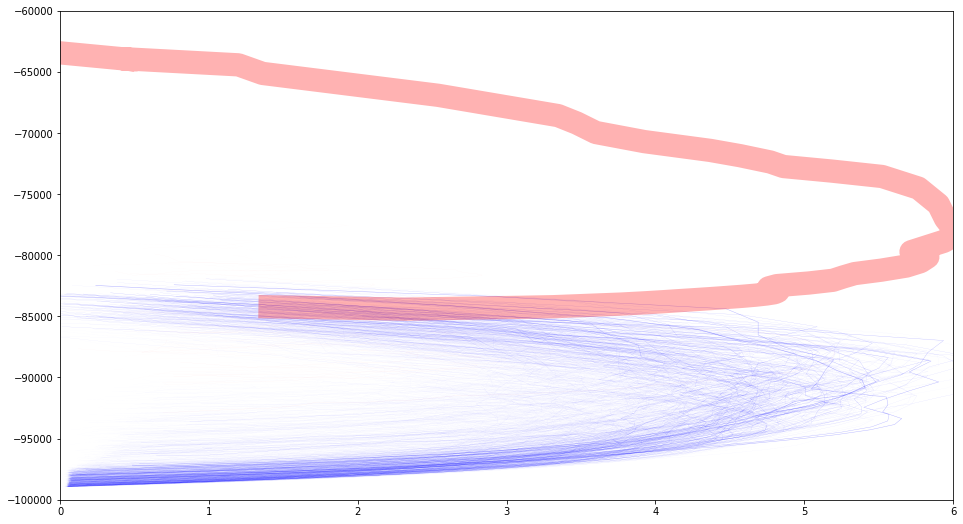

In [50]:
it = 6
plt.figure(figsize=(16,9))
PL = list_charac[it][:,0,5,2] > 90000
MO = list_charac[it][:,0,5,2] < 90000
MO[0] = False
for i in range(len(list_charac[it])):
    if PL[i]:
        plt.plot(list_charac[it][i,:,2,3],-list_charac[it][i,:,5,0],color='b',linewidth=np.max(list_area[it][i,:])/1000,alpha=0.3)
    if MO[i]:
        plt.plot(list_charac[it][i,:,2,3],-list_charac[it][i,:,5,0],color='r',linewidth=np.max(list_area[it][i,:])/1000,alpha=0.3)
plt.ylim([-100000,-60000])
plt.xlim([0,6])

(305.0, 320.0)

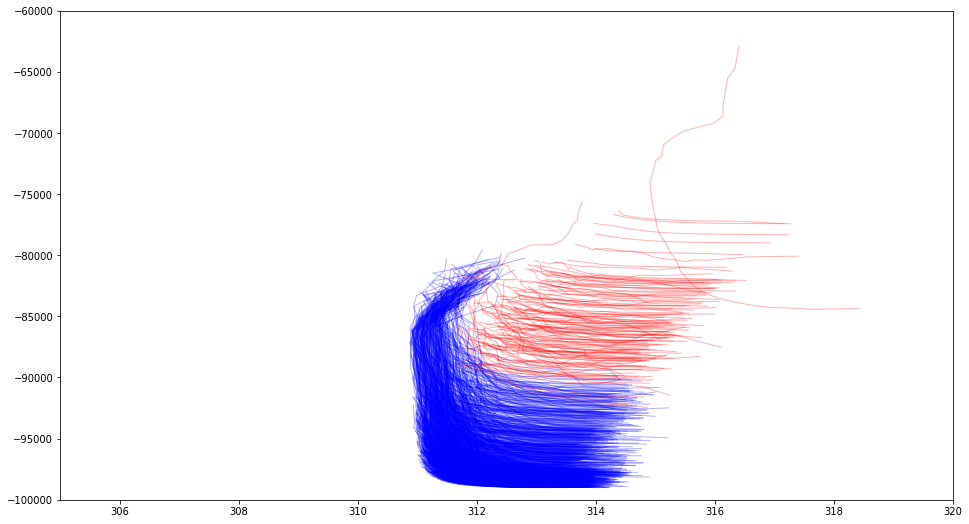

In [45]:
it = 7
plt.figure(figsize=(16,9))
PL = list_charac[it][:,0,5,2] > 90000
MO = list_charac[it][:,0,5,2] < 90000
MO[0] = False
for i in range(len(list_charac[it])):
    if PL[i]:
        plt.plot(list_charac[it][i,:,4,3],-list_charac[it][i,:,5,0],color='b',linewidth=1,alpha=0.3)
    if MO[i]:
        plt.plot(list_charac[it][i,:,4,3],-list_charac[it][i,:,5,0],color='r',linewidth=1,alpha=0.3)
plt.ylim([-100000,-60000])
plt.xlim([305,320])

In [43]:
list_area[it][i,:]

array([231640, 220871, 220539, 219583, 218849, 218255, 217821, 217588,
       217447, 217603, 218096, 218687, 219534, 220402, 221466, 222503,
       223499, 224375, 225153, 225981, 226983, 227806, 228734, 229735,
       230933, 232253, 233754, 235420, 237172, 238852, 240666, 242027,
       242196, 240848, 238271, 240557, 248400, 253577, 256009, 257553,
       258671, 259357, 260228, 260968, 261437, 261684, 261875, 262023,
       262081, 262124, 262131, 262142, 262144, 262144, 262144, 262144,
       262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
       262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
       262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
       262144, 262144, 262144, 262144, 262144], dtype=int32)